# Norm and Dir with Wider
__resnet32x4 and resnet 8x4__

In [2]:
# !pip install tensorboard --quiet

In [5]:
from utils.loss_functions import DKDLoss
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_package.models import Teacher, Student
from torchvision import datasets, transforms, models
import models_package
import time
import matplotlib.pyplot as plt

import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# new libraries
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof, load_wider
import boto3
import io
from utils.compare_tools import compare_model_size, compare_inference_time, compare_performance_metrics, plot_comparison
from utils.misc_tools import best_LR, best_LR_wider, train_teacher, retrieve_teacher_class_weights, new_teacher_class_weights
from utils.loss_functions import tkd_kdloss, DD_loss, AD_loss, RKDDistanceLoss, RKDAngleLoss

## Find best LR

In [7]:
# Hyperparameters
# Hyperparameters
learning_rate = 0.01
num_epochs = 1
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 30
step_size = 30
gamma = 0.1
beta = 0.0
patience = 7  # for early stopping

batch_size = 16
num_workers = 2

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
weight_decay_input = 5e-4
# epochs = 20
# T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping

## Load in Data

In [8]:
from data.data_loader import load_wider

train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']

class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])


trainloader, testloader  =  load_wider(train_file, test_file, class_labels, 
                                       batch_size, num_workers) 

Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


## Load in models

### resnet32x4_idenprof

In [9]:
# Instantiate the models

# Create instances of your models
# teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
# teacher_model.eval()  # Set teacher model to evaluation mode
# student_model = torchvision.models.resnet18(weights=None).cuda()

teacher_name = 'resnet32x4_idenprof'
teacher_model = models_package.__dict__[teacher_name](num_class=num_classes)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, num_classes)

In [10]:
teacher_model

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

### resnet8_idenprof

In [11]:
# teacher_name = 'resnet8_idenprof'
# teacher_model = models_package.__dict__[teacher_name](num_class=10)
# teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 10)

### resnet8x4_idenprof

In [12]:
student_name = 'resnet8x4_idenprof'
student_model = models_package.__dict__[student_name](num_class=num_classes)
student_model.fc = nn.Linear(student_model.fc.in_features, num_classes)

In [13]:
student_model

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding

In [9]:
# # Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)


criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Best LR

In [10]:
# first_batch = next(iter(trainloader))
# print(first_batch)
# print(len(first_batch))


In [11]:
# for i, (data1, data2, data3) in enumerate(tqdm(trainloader)):
#    print(data1)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 646/646 [04:38<00:00,  2.32it/s]


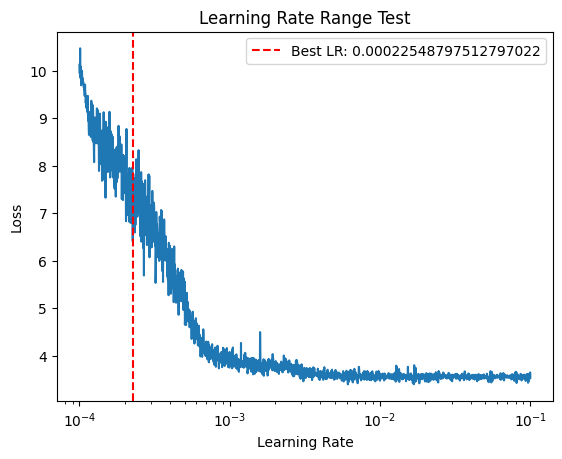

Best learning rate: 0.00022548797512797022


0.00022548797512797022

In [12]:
# teacher_lr = best_LR(teacher_model, trainloader, criterion,
#                      teacher_optimizer, teacher_scheduler, 
#                      device, num_epochs=3)

teacher_lr = best_LR_wider('resnet32x4_lr', teacher_model, trainloader, 
                           criterion, teacher_optimizer, teacher_scheduler, 
                           device, num_epochs=3)
teacher_lr

100%|████████████████████████████████████████████████████████████████████████████████████████████| 646/646 [01:34<00:00,  6.86it/s]


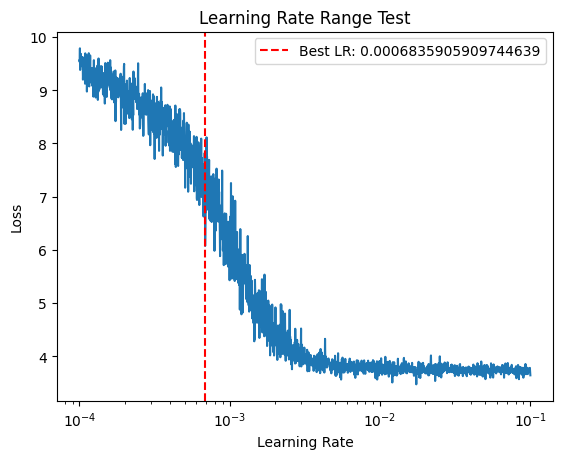

Best learning rate: 0.0006835905909744639


0.0006835905909744639

In [13]:
student_lr = best_LR_wider('resnet8x4_lr', student_model, trainloader, 
                           criterion, student_optimizer, student_scheduler, 
                           device, num_epochs=3)
student_lr

In [10]:
teacher_lr = 0.00022548797512797022
student_lr = 0.0006835905909744639

In [11]:
# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=student_lr, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=teacher_lr, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Train Leaderboard Teacher Models

In [12]:
# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, patience=5):
    model.train()
    model.to(device)
    best_train_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for i, batch in enumerate(tqdm(trainloader)):
            inputs, labels = batch['img'].to(device), batch['label'].to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            # loss = criterion(outputs, labels)
            loss = criterion(outputs[0], labels)
            loss.backward()
            optimizer.step
            
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  
        
        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            # checkpoint
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_prof_checkpoint.pth')
            torch.save(model, f'teacher_model_ckd_prof_checkpoint.pth')

        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

        scheduler.step()

    print("Finished Training Teacher")
    return model

In [13]:
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, 
              device, num_epochs=240)


 15%|████████████████████                                                                                                              | 100/646 [00:43<03:55,  2.32it/s]

[1, 100] loss: 10.256


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [01:26<03:12,  2.32it/s]

[1, 200] loss: 10.304


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [02:09<02:29,  2.32it/s]

[1, 300] loss: 10.305


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [02:52<01:45,  2.32it/s]

[1, 400] loss: 10.286


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [03:35<01:02,  2.32it/s]

[1, 500] loss: 10.336


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [04:19<00:19,  2.32it/s]

[1, 600] loss: 10.351


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 646/646 [04:38<00:00,  2.32it/s]
/home/ubuntu/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
 15%|████████████████████                                                                                                              | 100/646 [00:43<03:55,  2.32it/s]

[2, 100] loss: 10.326


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [01:26<03:12,  2.32it/s]

[2, 200] loss: 10.304


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [02:09<02:29,  2.32it/s]

[2, 300] loss: 10.342


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [02:52<01:45,  2.32it/s]

[2, 400] loss: 10.298


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [03:35<01:02,  2.32it/s]

[2, 500] loss: 10.291


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [04:18<00:19,  2.32it/s]

[2, 600] loss: 10.305


 15%|████████████████████                                                                                                              | 100/646 [00:43<03:55,  2.32it/s]

[3, 100] loss: 10.340


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [01:26<03:12,  2.32it/s]

[3, 200] loss: 10.297


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [02:09<02:29,  2.32it/s]

[3, 300] loss: 10.349


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [02:52<01:45,  2.32it/s]

[3, 400] loss: 10.338


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [03:35<01:02,  2.32it/s]

[3, 500] loss: 10.309


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [04:18<00:19,  2.32it/s]

[3, 600] loss: 10.291


 15%|████████████████████                                                                                                              | 100/646 [00:43<03:55,  2.32it/s]

[4, 100] loss: 10.276


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [01:26<03:12,  2.32it/s]

[4, 200] loss: 10.337


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [02:09<02:29,  2.32it/s]

[4, 300] loss: 10.306


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [02:52<01:46,  2.32it/s]

[4, 400] loss: 10.304


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [03:35<01:02,  2.32it/s]

[4, 500] loss: 10.324


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [04:18<00:19,  2.32it/s]

[4, 600] loss: 10.333


 15%|████████████████████                                                                                                              | 100/646 [00:43<03:55,  2.32it/s]

[5, 100] loss: 10.305


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [01:26<03:12,  2.32it/s]

[5, 200] loss: 10.283


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [02:09<02:29,  2.32it/s]

[5, 300] loss: 10.303


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [02:52<01:46,  2.32it/s]

[5, 400] loss: 10.313


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [03:35<01:02,  2.32it/s]

[5, 500] loss: 10.294


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [04:18<00:19,  2.32it/s]

[5, 600] loss: 10.304


 15%|████████████████████                                                                                                              | 100/646 [00:43<03:55,  2.32it/s]

[6, 100] loss: 10.338


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [01:26<03:12,  2.32it/s]

[6, 200] loss: 10.317


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [02:09<02:29,  2.32it/s]

[6, 300] loss: 10.295


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [02:52<01:46,  2.32it/s]

[6, 400] loss: 10.358


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [03:35<01:02,  2.32it/s]

[6, 500] loss: 10.301


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [04:18<00:19,  2.32it/s]

[6, 600] loss: 10.327


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 646/646 [04:38<00:00,  2.32it/s]

Early stopping
Finished Training Teacher


ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [25]:
# teacher_resnet32x4 = \
#     train_teacher('resnet_32x4', teacher_model, trainloader, criterion, teacher_optimizer, 
#                   teacher_scheduler, num_epochs=260, patience=5)


In [14]:
# Function to train the student model with knowledge distillation
def train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs, patience=5):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    best_train_loss = float('inf')  
    patience_counter = 0 

    for epoch in range(num_epochs):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        for i, batch in enumerate(tqdm(trainloader)):
            inputs, labels = batch['img'].to(device), batch['label'].to(device)
        # for i, (inputs, labels) in enumerate(tqdm(trainloader)):
        #     inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            ce_loss = criterion(student_outputs[0], labels)
            kd_loss = tkd_kdloss(student_outputs[0], teacher_outputs[0], temperature=temperature)  # from utils.loss_functions
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  

        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            torch.save(student.state_dict(), f'student_model_weights_ckd_prof_checkpoint.pth')
            torch.save(student, f'student_model_ckd_prof_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step() 

    print("Finished Training Student")
    return model

In [15]:
# student_resnet8x4 = \
#     train_student_with_distillation('resnet_8x4', student_model, trainloader, criterion, student_optimizer,
#                                      student_scheduler, num_epochs=260, patience=5)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation(student_model, teacher_model, trainloader, criterion, student_optimizer, 
                                student_scheduler, device, alpha, temperature, num_epochs=240)



 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[1, 100] loss: 1.005


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[1, 200] loss: 0.987


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[1, 300] loss: 0.960


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[1, 400] loss: 0.945


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[1, 500] loss: 0.942


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[1, 600] loss: 0.937


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[2, 100] loss: 0.920


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[2, 200] loss: 0.899


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[2, 300] loss: 0.897


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[2, 400] loss: 0.873


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[2, 500] loss: 0.874


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[2, 600] loss: 0.851


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[3, 100] loss: 0.841


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[3, 200] loss: 0.835


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[3, 300] loss: 0.826


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[3, 400] loss: 0.812


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[3, 500] loss: 0.801


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[3, 600] loss: 0.805


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[4, 100] loss: 0.779


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[4, 200] loss: 0.774


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[4, 300] loss: 0.752


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[4, 400] loss: 0.750


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[4, 500] loss: 0.732


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.42it/s]

[4, 600] loss: 0.734


 15%|████████████████████                                                                                                              | 100/646 [00:23<02:03,  4.43it/s]

[5, 100] loss: 0.717


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[5, 200] loss: 0.718


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[5, 300] loss: 0.706


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[5, 400] loss: 0.688


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[5, 500] loss: 0.675


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[5, 600] loss: 0.676


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[6, 100] loss: 0.674


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[6, 200] loss: 0.659


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[6, 300] loss: 0.644


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[6, 400] loss: 0.634


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[6, 500] loss: 0.628


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[6, 600] loss: 0.623


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[7, 100] loss: 0.621


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.42it/s]

[7, 200] loss: 0.614


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[7, 300] loss: 0.608


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.42it/s]

[7, 400] loss: 0.601


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.42it/s]

[7, 500] loss: 0.590


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.42it/s]

[7, 600] loss: 0.574


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[8, 100] loss: 0.574


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.42it/s]

[8, 200] loss: 0.564


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[8, 300] loss: 0.560


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[8, 400] loss: 0.566


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[8, 500] loss: 0.561


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[8, 600] loss: 0.555


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[9, 100] loss: 0.544


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[9, 200] loss: 0.541


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[9, 300] loss: 0.545


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[9, 400] loss: 0.539


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[9, 500] loss: 0.541


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[9, 600] loss: 0.525


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[10, 100] loss: 0.513


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.42it/s]

[10, 200] loss: 0.519


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:07<01:18,  4.43it/s]

[10, 300] loss: 0.514


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[10, 400] loss: 0.503


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[10, 500] loss: 0.513


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.42it/s]

[10, 600] loss: 0.519


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.42it/s]

[11, 100] loss: 0.511


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[11, 200] loss: 0.505


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[11, 300] loss: 0.499


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[11, 400] loss: 0.501


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[11, 500] loss: 0.494


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[11, 600] loss: 0.491


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[12, 100] loss: 0.486


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[12, 200] loss: 0.492


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[12, 300] loss: 0.481


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[12, 400] loss: 0.478


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[12, 500] loss: 0.488


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.42it/s]

[12, 600] loss: 0.487


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[13, 100] loss: 0.489


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[13, 200] loss: 0.482


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[13, 300] loss: 0.478


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[13, 400] loss: 0.473


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[13, 500] loss: 0.483


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[13, 600] loss: 0.479


 15%|████████████████████                                                                                                              | 100/646 [00:23<02:03,  4.43it/s]

[14, 100] loss: 0.464


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[14, 200] loss: 0.468


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:17,  4.44it/s]

[14, 300] loss: 0.470


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.42it/s]

[14, 400] loss: 0.463


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[14, 500] loss: 0.465


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.42it/s]

[14, 600] loss: 0.469


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[15, 100] loss: 0.451


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[15, 200] loss: 0.461


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[15, 300] loss: 0.458


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[15, 400] loss: 0.472


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.42it/s]

[15, 500] loss: 0.457


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[15, 600] loss: 0.454


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[16, 100] loss: 0.458


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[16, 200] loss: 0.457


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[16, 300] loss: 0.459


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[16, 400] loss: 0.451


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[16, 500] loss: 0.454


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[16, 600] loss: 0.452


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[17, 100] loss: 0.449


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[17, 200] loss: 0.452


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[17, 300] loss: 0.451


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.42it/s]

[17, 400] loss: 0.454


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.42it/s]

[17, 500] loss: 0.444


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[17, 600] loss: 0.452


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[18, 100] loss: 0.447


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[18, 200] loss: 0.454


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[18, 300] loss: 0.453


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.42it/s]

[18, 400] loss: 0.440


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[18, 500] loss: 0.441


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[18, 600] loss: 0.451


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[19, 100] loss: 0.441


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[19, 200] loss: 0.446


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[19, 300] loss: 0.453


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.42it/s]

[19, 400] loss: 0.442


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[19, 500] loss: 0.444


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[19, 600] loss: 0.438


 15%|████████████████████                                                                                                              | 100/646 [00:23<02:03,  4.43it/s]

[20, 100] loss: 0.445


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[20, 200] loss: 0.448


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[20, 300] loss: 0.444


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[20, 400] loss: 0.445


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[20, 500] loss: 0.439


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[20, 600] loss: 0.432


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[21, 100] loss: 0.440


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[21, 200] loss: 0.436


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.42it/s]

[21, 300] loss: 0.439


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[21, 400] loss: 0.442


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[21, 500] loss: 0.433


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[21, 600] loss: 0.441


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.42it/s]

[22, 100] loss: 0.436


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[22, 200] loss: 0.440


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.42it/s]

[22, 300] loss: 0.439


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[22, 400] loss: 0.446


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[22, 500] loss: 0.438


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[22, 600] loss: 0.436


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[23, 100] loss: 0.438


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[23, 200] loss: 0.443


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[23, 300] loss: 0.435


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[23, 400] loss: 0.444


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[23, 500] loss: 0.445


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[23, 600] loss: 0.430


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[24, 100] loss: 0.441


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[24, 200] loss: 0.435


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[24, 300] loss: 0.428


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[24, 400] loss: 0.440


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[24, 500] loss: 0.438


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[24, 600] loss: 0.436


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[25, 100] loss: 0.441


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[25, 200] loss: 0.438


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[25, 300] loss: 0.434


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[25, 400] loss: 0.434


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[25, 500] loss: 0.436


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[25, 600] loss: 0.446


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.42it/s]

[26, 100] loss: 0.441


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[26, 200] loss: 0.435


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[26, 300] loss: 0.436


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[26, 400] loss: 0.438


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[26, 500] loss: 0.430


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[26, 600] loss: 0.435


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[27, 100] loss: 0.438


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[27, 200] loss: 0.432


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.41it/s]

[27, 300] loss: 0.428


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[27, 400] loss: 0.433


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[27, 500] loss: 0.437


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[27, 600] loss: 0.435


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[28, 100] loss: 0.438


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[28, 200] loss: 0.429


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[28, 300] loss: 0.429


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[28, 400] loss: 0.435


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.42it/s]

[28, 500] loss: 0.451


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.42it/s]

[28, 600] loss: 0.432


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.42it/s]

[29, 100] loss: 0.426


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[29, 200] loss: 0.433


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[29, 300] loss: 0.426


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[29, 400] loss: 0.436


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[29, 500] loss: 0.433


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.42it/s]

[29, 600] loss: 0.431


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[30, 100] loss: 0.431


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[30, 200] loss: 0.442


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[30, 300] loss: 0.438


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[30, 400] loss: 0.432


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[30, 500] loss: 0.431


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[30, 600] loss: 0.429


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[31, 100] loss: 0.429


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[31, 200] loss: 0.428


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[31, 300] loss: 0.434


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[31, 400] loss: 0.428


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[31, 500] loss: 0.432


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[31, 600] loss: 0.429


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[32, 100] loss: 0.436


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[32, 200] loss: 0.429


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[32, 300] loss: 0.433


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[32, 400] loss: 0.432


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[32, 500] loss: 0.427


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[32, 600] loss: 0.426


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[33, 100] loss: 0.439


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[33, 200] loss: 0.427


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[33, 300] loss: 0.429


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.42it/s]

[33, 400] loss: 0.427


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[33, 500] loss: 0.432


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[33, 600] loss: 0.423


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[34, 100] loss: 0.430


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[34, 200] loss: 0.440


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[34, 300] loss: 0.429


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[34, 400] loss: 0.428


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[34, 500] loss: 0.429


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[34, 600] loss: 0.429


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[35, 100] loss: 0.437


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[35, 200] loss: 0.426


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[35, 300] loss: 0.429


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[35, 400] loss: 0.428


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[35, 500] loss: 0.430


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[35, 600] loss: 0.439


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[36, 100] loss: 0.431


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[36, 200] loss: 0.424


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[36, 300] loss: 0.442


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[36, 400] loss: 0.429


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:33,  4.42it/s]

[36, 500] loss: 0.435


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[36, 600] loss: 0.427


 15%|████████████████████                                                                                                              | 100/646 [00:23<02:03,  4.43it/s]

[37, 100] loss: 0.437


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[37, 200] loss: 0.425


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[37, 300] loss: 0.428


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.43it/s]

[37, 400] loss: 0.427


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[37, 500] loss: 0.426


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[37, 600] loss: 0.428


 15%|████████████████████                                                                                                              | 100/646 [00:22<02:03,  4.43it/s]

[38, 100] loss: 0.425


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:45<01:40,  4.43it/s]

[38, 200] loss: 0.422


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [01:08<01:18,  4.43it/s]

[38, 300] loss: 0.435


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:30<00:55,  4.42it/s]

[38, 400] loss: 0.439


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:53<00:32,  4.43it/s]

[38, 500] loss: 0.427


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [02:15<00:10,  4.43it/s]

[38, 600] loss: 0.435


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 646/646 [02:26<00:00,  4.42it/s]


Early stopping
Finished Training Student


NameError: name 'model' is not defined

In [ ]:
###################### Testing 1 ######################
# Save the student and teacher model weights and architecture
torch.save(teacher_model.state_dict(), 'teacher_model_weights_resnet324_wider.pth')
torch.save(teacher_model, 'teacher_model_resnet324_wider.pth')
print('teacher weights and architecture saved and exported')

torch.save(student_model.state_dict(), 'student_model_weights_resnet84_wider.pth')
torch.save(student_model, 'student_model_resnet84_wider.pth')
print('student weights and architecture saved and exported')

In [14]:
###################### Saving weights and movel using s3 bucket ######################

session = boto3.session.Session()
s3 = session.client('s3')

bucket_name = '210bucket' 

# Teacher Model
#### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
teacher_model_weights_path = 'weights/teacher_model_weights_resnet324_wider.pth'
teacher_model_path = 'models/teacher_model_resnet324_wider.pth'

# Save state dict to buffer
teacher_model_weights_buffer = io.BytesIO()
torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
teacher_model_weights_buffer.seek(0)

# Save entire model to buffer
teacher_model_buffer = io.BytesIO()
torch.save(teacher_model, teacher_model_buffer)
teacher_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
print('teacher weights and architecture saved and exported to S3')

# Student Model
#### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
student_model_weights_path = 'weights/student_model_weights_resnet84_wider.pth' 
student_model_path = 'models/student_model_resnet84_wider.pth'

# Save state dict to buffer
student_model_weights_buffer = io.BytesIO()
torch.save(student_model.state_dict(), student_model_weights_buffer)
student_model_weights_buffer.seek(0)

# Save entire model to buffer
student_model_buffer = io.BytesIO()
torch.save(student_model, student_model_buffer)
student_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=student_model_weights_path, Body=student_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=student_model_path, Body=student_model_buffer)
print('student weights and architecture saved and exported to S3')

teacher weights and architecture saved and exported to S3
student weights and architecture saved and exported to S3


## Trainloader and Testloader Plots

In [16]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs[0], dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs[0], dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }
    
def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.show()

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the student model architecture and weights
student_model = torch.load('student_model_resnet84_wider.pth')
student_model.load_state_dict(torch.load('student_model_weights_resnet84_wider.pth'))
student_model = student_model.to(device)

# Load the student model architecture and weights
teacher_model = torch.load('teacher_model_resnet324_wider.pth')
teacher_model.load_state_dict(torch.load('teacher_model_weights_resnet324_wider.pth'))
teacher_model = teacher_model.to(device)

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': (0.0, 0.0668345602479659), 'precision': (0.0, 0.0526978574050415), 'recall': (0.0, 0.0668345602479659), 'f1': (0.0, 0.029087821348922866)}


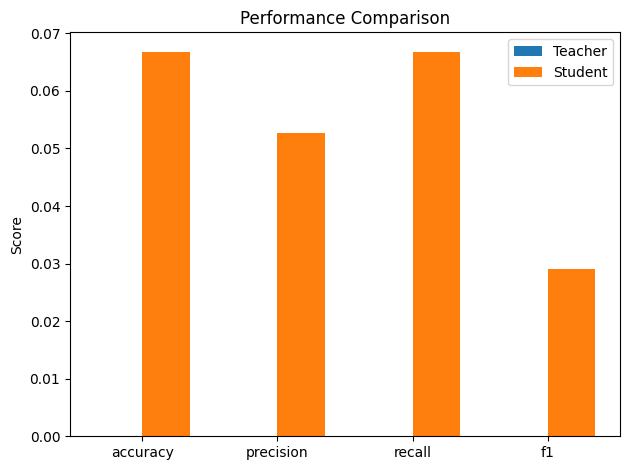

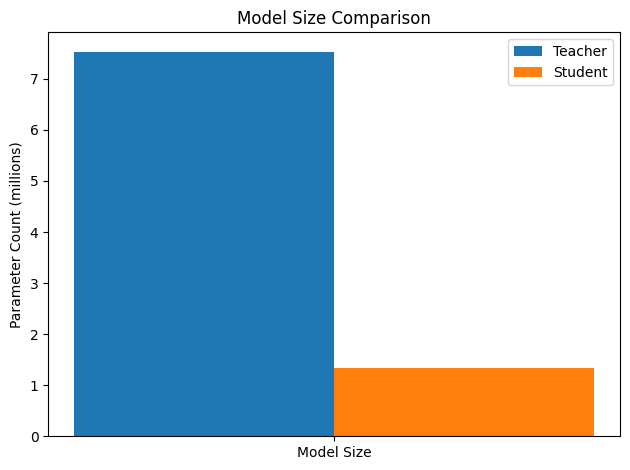

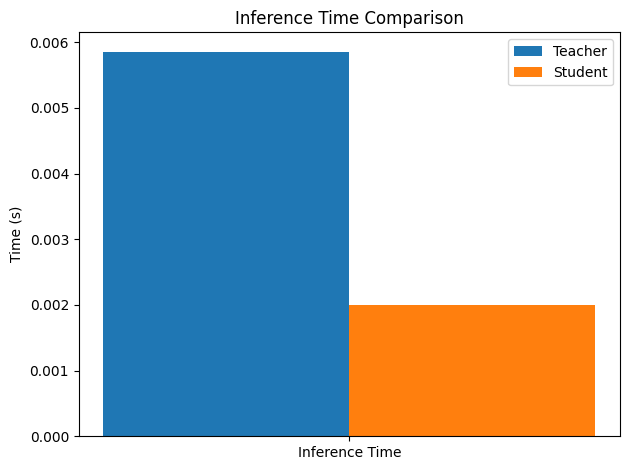

In [18]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)['metrics']
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]

student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

{'accuracy': (0.0, 0.0645815233130611), 'precision': (0.0, 0.0688906477301385), 'recall': (0.0, 0.0645815233130611), 'f1': (0.0, 0.03758843630661484)}


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


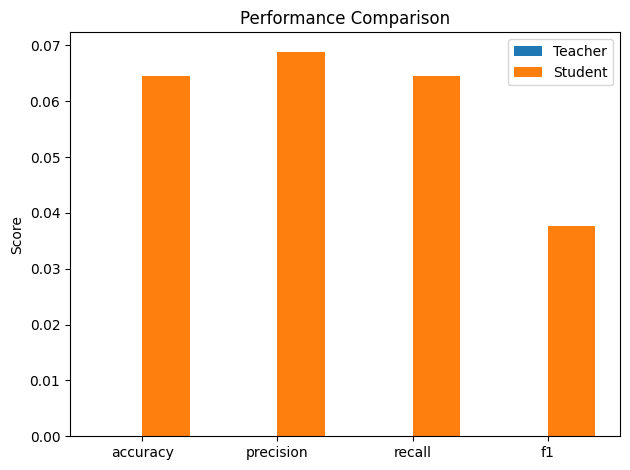

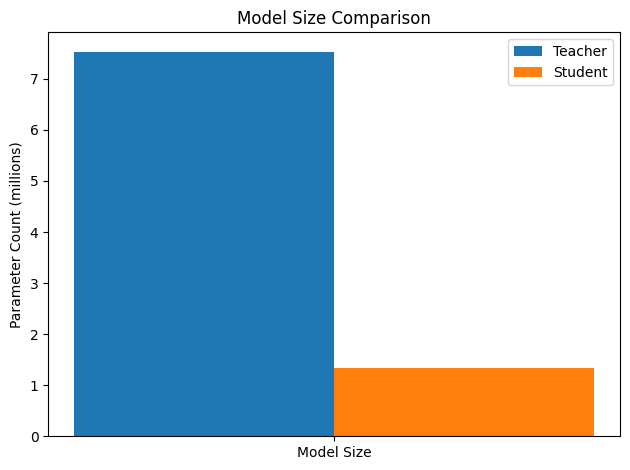

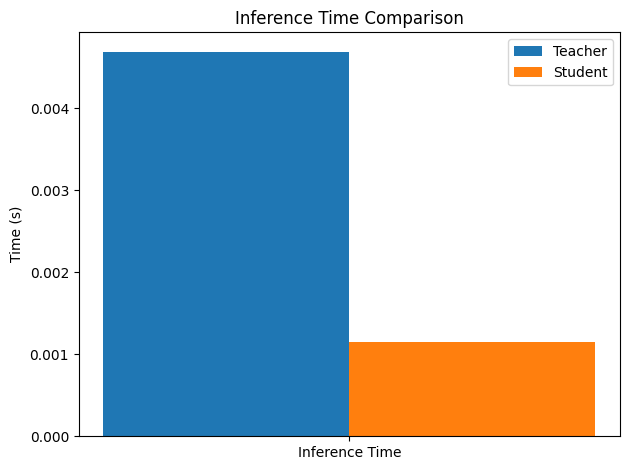

In [19]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)['metrics']
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]

student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

## Extract Class Weights for Norm and Direction

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the student model architecture and weights
student_model = torch.load('student_model_resnet84_wider.pth')
student_model.load_state_dict(torch.load('student_model_weights_resnet84_wider.pth'))
student_model = student_model.to(device)

# Load the student model architecture and weights
teacher_model = torch.load('teacher_model_resnet324_wider.pth')
teacher_model.load_state_dict(torch.load('teacher_model_weights_resnet324_wider.pth'))
teacher_model = teacher_model.to(device)

In [30]:
def get_emb_fea(model, dataloader, batch_size):
    ''' Used to extract the feature embeddings in a teacher model '''
    model.eval()

    EMB = {}

    with torch.no_grad():
        for batch in dataloader:
            # images = batch['img'].to(device)
            # labels = batch['label'].to(device)
            images, labels = batch['img'].cuda(), batch['label'].cuda()

            # compute output
            emb_fea, logits = model(images, embed=True)

            for emb, i in zip(emb_fea, labels):
                i = i.item()
                emb_size = len(emb) 
                # print(len(emb))
                if str(i) in EMB:
                    for j in range(emb_size):
                        EMB[str(i)][j].append(round(emb[j].item(), 4))
                else:
                    EMB[str(i)] = [[] for _ in range(emb_size)]
                    for j in range(emb_size):
                        EMB[str(i)][j].append(round(emb[j].item(), 4))

    for key, value in EMB.items():
        for i in range(emb_size):
            EMB[key][i] = round(np.array(EMB[key][i]).mean(), 4)

    return EMB

In [31]:
get_emb_fea(student_model, trainloader, batch_size)


{'28': [9.3603,
  8.9339,
  8.9152,
  8.9247,
  8.9337,
  8.9309,
  8.7336,
  8.7118,
  8.5832,
  8.5797,
  8.5957,
  8.6064,
  8.5625,
  8.4445,
  8.6858,
  8.5344,
  8.5374,
  8.543,
  8.5686,
  8.5546,
  8.42,
  8.7111,
  8.5033,
  8.4949,
  8.4946,
  8.5094,
  8.4954,
  8.4015,
  8.7089,
  8.4738,
  8.4738,
  8.4583,
  8.4919,
  8.4925,
  8.3739,
  8.5939,
  8.3872,
  8.3779,
  8.3982,
  8.4031,
  8.3893,
  8.2839,
  6.6312,
  6.2823,
  6.2838,
  6.3047,
  6.2591,
  6.2627,
  6.13,
  0.2203,
  0.2579,
  0.2556,
  0.2415,
  0.25,
  0.2316,
  0.2308,
  0.2564,
  0.3159,
  0.3228,
  0.315,
  0.3202,
  0.3138,
  0.2825,
  0.2704,
  0.3775,
  0.3951,
  0.3742,
  0.3747,
  0.3408,
  0.2832,
  0.2909,
  0.3909,
  0.4319,
  0.4354,
  0.3979,
  0.3695,
  0.2999,
  0.2557,
  0.3464,
  0.3816,
  0.3827,
  0.3722,
  0.3383,
  0.3068,
  0.2629,
  0.3436,
  0.3377,
  0.3396,
  0.3356,
  0.3143,
  0.2735,
  0.3639,
  0.4053,
  0.3709,
  0.3904,
  0.4026,
  0.3929,
  0.3696,
  0.2996,
  0.3425,
  

In [32]:
import boto3
import io
import os
import torch
import torch.nn as nn
from collections import OrderedDict
import json
import models_package  
import numpy as np


# # Function definitions


#### without mean
# def get_emb_fea(model, dataloader, batch_size):
#     # Define the device
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model.to(device)
#     model.eval() 
#     embeddings = []

#     with torch.no_grad(): 
#         for data in dataloader:
#             inputs, labels = data
#             inputs = inputs.to(device)

#             output = model(inputs)
#             if isinstance(output, tuple):
#                 output = output[0]

#             embeddings.append(output.cpu().numpy())

#     embeddings = np.concatenate(embeddings, axis=0).tolist() 
#     return embeddings


#### with mean
def get_emb_fea(model, dataloader, batch_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval() 
    class_embeddings = {}

    with torch.no_grad(): 
        for batch in dataloader:
            inputs = batch['img']
            labels = batch['label']

            inputs = inputs.to(device)
            labels = labels.cpu().numpy()

            output = model(inputs)
            if isinstance(output, tuple):
                output = output[0]

            embeddings = output.cpu().numpy()

            for emb, label in zip(embeddings, labels):
                label = int(label)  
                if label not in class_embeddings:
                    class_embeddings[label] = []
                class_embeddings[label].append(emb)

    class_mean_embeddings = {label: np.mean(np.array(embs), axis=0).tolist() 
                             for label, embs in class_embeddings.items()}

    return class_mean_embeddings


#### the original function with a small update
# def get_emb_fea(model, dataloader, batch_size):
#     ''' Used to extract the feature embeddings in a teacher model '''
#     model.eval()

#     EMB = {}

#     with torch.no_grad():
#         for images, labels in dataloader:
#             images, labels = images.cuda(), labels.cuda()

#             # compute output
#             emb_fea, logits = model(images, embed=True)

#             for emb, i in zip(emb_fea, labels):
#                 i = i.item()
#                 emb_size = len(emb) 
#                 if str(i) in EMB:
#                     for j in range(emb_size):
#                         EMB[str(i)][j].append(round(emb[j].item(), 4))
#                 else:
#                     EMB[str(i)] = [[] for _ in range(emb_size)]
#                     for j in range(emb_size):
#                         EMB[str(i)][j].append(round(emb[j].item(), 4))

#     for key, value in EMB.items():
#         for i in range(emb_size):
#             EMB[key][i] = round(np.array(EMB[key][i]).mean(), 4)

#     return EMB

    

def retrieve_teacher_class_weights(model_name, model_weight_path, num_class, data_name, dataloader, batch_size, bucket_name):
    ''' Use the extracted feature embeddings to create a json of class means for teacher'''

    session = boto3.session.Session()
    s3 = session.client('s3')

    teacher_model_weights_buffer = io.BytesIO()
    s3.download_fileobj(bucket_name, model_weight_path, teacher_model_weights_buffer)
    teacher_model_weights_buffer.seek(0)  

    # Load the model
    model = models_package.__dict__[model_name](num_class=num_class)
    checkpoint = torch.load(teacher_model_weights_buffer)
    print("Keys in checkpoint:", checkpoint.keys())

    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        name = k[7:] if k.startswith('module.') else k
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    model.eval()

    for param in model.parameters():
        param.requires_grad = False
    
    model = model.cuda()

    # emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    # emb_json = json.dumps(emb, indent=4)
    # with open("./class_means/{}_embedding_fea/{}.json".format(data_name, model_name), 'w', encoding='utf-8') as f:
    #     f.write(emb_json)

    emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    emb_json = json.dumps(emb, indent=4)

    # Create the directory if it doesn't exist
    output_dir = "./class_means/{}_embedding_fea".format(data_name)
    os.makedirs(output_dir, exist_ok=True)

    with open("{}/{}.json".format(output_dir, model_name), 'w', encoding='utf-8') as f:
        f.write(emb_json)

# # Calling the function
# model_name = 'resnet32x4_wider'
# model_weight_path = 'teacher_model_weights_resnet324_wider.pth'
# num_class = 10
# data_name = 'wider'  
# batch_size = 0  
# bucket_name = '210bucket'  

# retrieve_teacher_class_weights(model_name, model_weight_path, num_class, data_name, testloader, batch_size, bucket_name)


In [33]:
get_emb_fea(student_model, trainloader, batch_size)

{1: [9.330910682678223,
  9.000415802001953,
  8.967453956604004,
  8.98067855834961,
  8.99847412109375,
  8.95081901550293,
  8.721355438232422,
  8.591106414794922,
  8.659330368041992,
  8.656986236572266,
  8.643922805786133,
  8.644183158874512,
  8.62740707397461,
  8.428224563598633,
  8.57887077331543,
  8.583770751953125,
  8.58267879486084,
  8.59650993347168,
  8.562418937683105,
  8.577913284301758,
  8.420734405517578,
  8.58869457244873,
  8.514253616333008,
  8.533584594726562,
  8.514440536499023,
  8.52325439453125,
  8.496740341186523,
  8.35945987701416,
  8.581132888793945,
  8.496588706970215,
  8.49138069152832,
  8.470072746276855,
  8.449179649353027,
  8.468568801879883,
  8.323911666870117,
  8.507179260253906,
  8.424667358398438,
  8.414444923400879,
  8.374612808227539,
  8.405298233032227,
  8.3865966796875,
  8.21251392364502,
  6.548079490661621,
  6.248414993286133,
  6.250553131103516,
  6.2490553855896,
  6.261627197265625,
  6.245121002197266,
  6.0

In [ ]:
## backup
# Save the student and teacher model weights and architecture
torch.save(teacher_model.state_dict(), 'teacher_model_weights_resnet8_4.pth')
torch.save(teacher_model, 'testing_teacher_model_resnet8_4.pth')
print('student weights and architecture saved and exported')

In [ ]:
###################### Saving weights and movel using s3 bucket ######################

session = boto3.session.Session()
s3 = session.client('s3')

bucket_name = '210bucket' 

# Teacher Model
#### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
teacher_model_weights_path = 'weights/teacher_model_weights_resnet8_4.pth'
teacher_model_path = 'models/testing_teacher_model_resnet8_4.pth'

# Save state dict to buffer
teacher_model_weights_buffer = io.BytesIO()
torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
teacher_model_weights_buffer.seek(0)

# Save entire model to buffer
teacher_model_buffer = io.BytesIO()
torch.save(teacher_model, teacher_model_buffer)
teacher_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
print('teacher weights and architecture saved and exported to S3')

# # Student Model
# #### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
# student_model_weights_path = 'weights/student_model_weights.pth' 
# student_model_path = 'models/student_model.pth'

# # Save state dict to buffer
# student_model_weights_buffer = io.BytesIO()
# torch.save(student_model.state_dict(), student_model_weights_buffer)
# student_model_weights_buffer.seek(0)

# # Save entire model to buffer
# student_model_buffer = io.BytesIO()
# torch.save(student_model, student_model_buffer)
# student_model_buffer.seek(0)

# # Upload to S3
# s3.put_object(Bucket=bucket_name, Key=student_model_weights_path, Body=student_model_weights_buffer)
# s3.put_object(Bucket=bucket_name, Key=student_model_path, Body=student_model_buffer)
# print('student weights and architecture saved and exported to S3')

## Read Models and Weights

In [6]:
# Initialize a session using Boto3 again 
session = boto3.session.Session()

s3 = session.client('s3')
bucket_name = '210bucket'  

teacher_model_weights_s3_path = 'weights/idenprof_teacher_resnet32x4_weights.pth'
# student_model_weights_s3_path = 'weights/testing_student_model_weights_rkd_prof.pth'

# Read files directly into memory
teacher_model_weights_buffer = io.BytesIO()
# student_model_weights_buffer = io.BytesIO()

s3.download_fileobj(bucket_name, teacher_model_weights_s3_path, teacher_model_weights_buffer)
# s3.download_fileobj(bucket_name, student_model_weights_s3_path, student_model_weights_buffer)

# Load the weights into the models
teacher_model_weights_buffer.seek(0)  # Move to the beginning of the buffer
# student_model_weights_buffer.seek(0)  

######## MAKE SURE THAT YOU HAVE THE CORRECT MODELS FOR WEIGHTS ########
# Teacher
# teacher_name = 'resnet8x4_idenprof'
teacher_name = 'resnet32x4_idenprof'
teacher_model = models_package.__dict__[teacher_name](num_class=10)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 10)
teacher_model.load_state_dict(torch.load(teacher_model_weights_buffer))
teacher_model.eval()
# # Student
# student_model = CustomResNet18()
# student_model.load_state_dict(torch.load(student_model_weights_buffer))


ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [13]:
import boto3
import io
import os
import torch
import torch.nn as nn
from collections import OrderedDict
import json
import models_package  
import numpy as np


# # Function definitions


#### without mean
# def get_emb_fea(model, dataloader, batch_size):
#     # Define the device
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model.to(device)
#     model.eval() 
#     embeddings = []

#     with torch.no_grad(): 
#         for data in dataloader:
#             inputs, labels = data
#             inputs = inputs.to(device)

#             output = model(inputs)
#             if isinstance(output, tuple):
#                 output = output[0]

#             embeddings.append(output.cpu().numpy())

#     embeddings = np.concatenate(embeddings, axis=0).tolist() 
#     return embeddings


#### with mean
def get_emb_fea(model, dataloader, batch_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval() 
    class_embeddings = {}

    with torch.no_grad(): 
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.cpu().numpy()

            output = model(inputs)
            if isinstance(output, tuple):
                output = output[0]

            embeddings = output.cpu().numpy()

            for emb, label in zip(embeddings, labels):
                label = int(label)  
                if label not in class_embeddings:
                    class_embeddings[label] = []
                class_embeddings[label].append(emb)

    class_mean_embeddings = {label: np.mean(np.array(embs), axis=0).tolist() 
                             for label, embs in class_embeddings.items()}

    return class_mean_embeddings


#### the original function with a small update
# def get_emb_fea(model, dataloader, batch_size):
#     ''' Used to extract the feature embeddings in a teacher model '''
#     model.eval()

#     EMB = {}

#     with torch.no_grad():
#         for images, labels in dataloader:
#             images, labels = images.cuda(), labels.cuda()

#             # compute output
#             emb_fea, logits = model(images, embed=True)

#             for emb, i in zip(emb_fea, labels):
#                 i = i.item()
#                 emb_size = len(emb) 
#                 if str(i) in EMB:
#                     for j in range(emb_size):
#                         EMB[str(i)][j].append(round(emb[j].item(), 4))
#                 else:
#                     EMB[str(i)] = [[] for _ in range(emb_size)]
#                     for j in range(emb_size):
#                         EMB[str(i)][j].append(round(emb[j].item(), 4))

#     for key, value in EMB.items():
#         for i in range(emb_size):
#             EMB[key][i] = round(np.array(EMB[key][i]).mean(), 4)

#     return EMB

    

def retrieve_teacher_class_weights(model_name, model_weight_path, num_class, data_name, dataloader, batch_size, bucket_name):
    ''' Use the extracted feature embeddings to create a json of class means for teacher'''

    session = boto3.session.Session()
    s3 = session.client('s3')

    teacher_model_weights_buffer = io.BytesIO()
    s3.download_fileobj(bucket_name, model_weight_path, teacher_model_weights_buffer)
    teacher_model_weights_buffer.seek(0)  

    # Load the model
    model = models_package.__dict__[model_name](num_class=num_class)
    checkpoint = torch.load(teacher_model_weights_buffer)
    print("Keys in checkpoint:", checkpoint.keys())

    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        name = k[7:] if k.startswith('module.') else k
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    model.eval()

    for param in model.parameters():
        param.requires_grad = False
    
    model = model.cuda()

    # emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    # emb_json = json.dumps(emb, indent=4)
    # with open("./class_means/{}_embedding_fea/{}.json".format(data_name, model_name), 'w', encoding='utf-8') as f:
    #     f.write(emb_json)

    emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    emb_json = json.dumps(emb, indent=4)

    # Create the directory if it doesn't exist
    output_dir = "./class_means/{}_embedding_fea".format(data_name)
    os.makedirs(output_dir, exist_ok=True)

    with open("{}/{}.json".format(output_dir, model_name), 'w', encoding='utf-8') as f:
        f.write(emb_json)

# Calling the function
model_name = 'resnet32x4_idenprof'
model_weight_path = 'weights/idenprof_teacher_resnet32x4_weights.pth'
num_class = 10
data_name = 'idenprof'  
batch_size = 0  
bucket_name = '210bucket'  

retrieve_teacher_class_weights(model_name, model_weight_path, num_class, data_name, testloader, batch_size, bucket_name)


Keys in checkpoint: odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked'

## LB Help

1. loading in model weights and idenprof dataset from s3 (LB will set up) __COMPLETE__
2. save model weights to s3 bucket (moving forward) __COMPLETE__
3. Teachers: help running resnet-34x2 (LB) -- needs to be trained on idenprof __COMPLETE__
4. Make sure that resnet-8x4 is running __COMPLETE__
5. Student: shufflenet-v1  -- just need to make them run